In [1]:
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import gensim

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('../dmdlassignment2/AnnoMI/dataset.csv')
df.head()

,transcript_id,mi_quality,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,main_therapist_behaviour,client_talk_type
0,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,0,therapist,00:00:13,Thanks for filling it out. We give this form t...,question,NaN
1,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,1,client,00:00:24,Sure.,NaN,neutral
2,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,2,therapist,00:00:25,"So, let's see. It looks that you put-- You dri...",therapist_input,NaN
3,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,3,client,00:00:34,Mm-hmm.,NaN,neutral
4,0,high,"NEW VIDEO: Brief intervention: ""Barbara""",https://www.youtube.com/watch?v=PaSKcfTmFEk,reducing alcohol consumption,4,therapist,00:00:34,-and you usually have three to four drinks whe...,therapist_input,NaN


# Data Cleaning and Preprocessing

In [3]:
import string
import re

stop_words = set(stopwords.words('english'))

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize(text):
    split=re.split("\W+",text.lower()) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stop_words]
    return text

def lemmatize(text):
    lemmatized_words = []
    for word in text:
        lemmatized_words.append(lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_words)
    

In [26]:
# Remove null values
def transform(dataframe):
    for index, row in dataframe.iterrows():
        dataframe['avg_utterance_length'][index] = len(row['utterance_text'].split())
        words = word_tokenize(row['utterance_text'])

        dataframe['utterance_text'][index] = lemmatize(remove_stopwords(tokenize(remove_punctuation(row['utterance_text']))))
        
        if (pd.isnull(row['client_talk_type'])):
            dataframe['behaviour_type'][index] = row['main_therapist_behaviour']
        else:
            dataframe['behaviour_type'][index] = row['client_talk_type']

In [27]:
col = ['mi_quality', 'interlocutor', 'topic', 'utterance_text', 'main_therapist_behaviour', 'client_talk_type']
df = df[col]
df.insert(loc=5,
          column='avg_utterance_length',
          value=0)
df.insert(loc=5,
          column='behaviour_type',
          value='')

df_therapist = df[df['interlocutor'] == 'therapist']
df_client = df[df['interlocutor'] == 'client']

transform(df_therapist)
transform(df_client)

df_therapist.head()
# df_client.head()

,mi_quality,interlocutor,topic,utterance_text,main_therapist_behaviour,behaviour_type,avg_utterance_length,client_talk_type
0,high,therapist,reducing alcohol consumption,thank fill give form everyone year regardless ...,question,question,39,NaN
2,high,therapist,reducing alcohol consumption,let see look put drink alcohol least four time...,therapist_input,therapist_input,19,NaN
4,high,therapist,reducing alcohol consumption,usually three four drink drink,therapist_input,therapist_input,12,NaN
6,high,therapist,reducing alcohol consumption,okay thats least 12 drink week,therapist_input,therapist_input,8,NaN
8,high,therapist,reducing alcohol consumption,okay know role um talk alcohol use share infor...,therapist_input,therapist_input,44,NaN


## The following graphs shows distribution of the classes based on the interlocutor and average utterance length

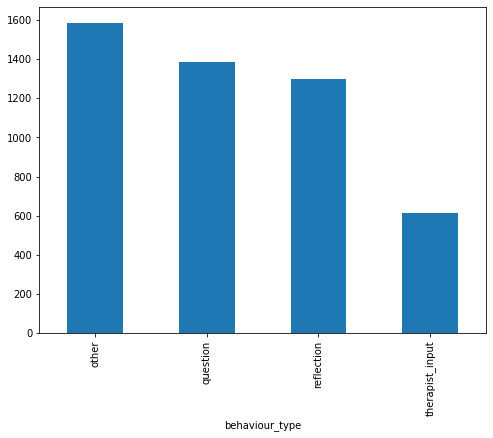

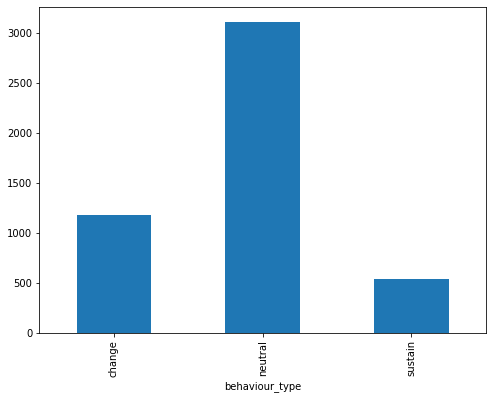

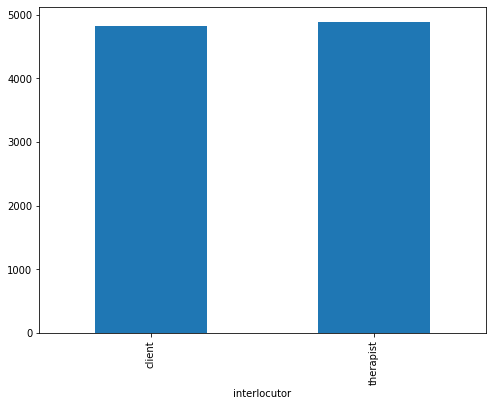

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_therapist.groupby('behaviour_type').interlocutor.count().plot.bar(ylim=0)
plt.show()

fig = plt.figure(figsize=(8,6))
df_client.groupby('behaviour_type').interlocutor.count().plot.bar(ylim=0)
plt.show()

fig = plt.figure(figsize=(8,6))
df.groupby('interlocutor').avg_utterance_length.count().plot.bar(ylim=0)
plt.show()

## Mean, standard deviation and 25%-50%-75% of the utterance length for each interlocutor

In [86]:
mean_interlocutor_therapist = df_therapist['interlocutor'].count()/df['interlocutor'].count()
mean_interlocutor_client = df_client['interlocutor'].count()/df['interlocutor'].count()
mean_interlocutor
temp_df = pd.DataFrame(columns=['Interlocutor', 'Mean Interlocutor Utterances', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
# temp_df['statistics'] = df_therapist['avg_utterance_length'].describe()
# temp_df['interlocutor'] = 'therapist'
therapist = ['therapist', mean_interlocutor_therapist]
therapist.extend(df_therapist['avg_utterance_length'].describe().values)
temp_df.loc[0] = therapist

client = ['client', mean_interlocutor_client]
client.extend(df_client['avg_utterance_length'].describe().values)
temp_df.loc[1] = client

temp_df

,Interlocutor,Mean Interlocutor Utterances,count,mean,std,min,25%,50%,75%,max
0,therapist,0.503351,4882.0,16.653830,20.265038,1.0,2.0,10.0,23.0,190.0
1,client,0.496649,4817.0,14.974258,20.386643,1.0,2.0,8.0,20.0,246.0


In [6]:
processed_data = {'therapist': {}, 'client': {}}

def extract_labels(dataframe, key):
    dataframe['behaviour_type_id'] = dataframe['behaviour_type'].factorize()[0]
    processed_data[key]['behaviour_type_id_df'] = dataframe[['behaviour_type', 'behaviour_type_id']].drop_duplicates().sort_values('behaviour_type_id')
    processed_data[key]['behaviour_to_id'] = dict(processed_data[key]['behaviour_type_id_df'].values)
    processed_data[key]['id_to_behaviour'] = dict(processed_data[key]['behaviour_type_id_df'][['behaviour_type_id', 'behaviour_type']].values)

In [7]:
extract_labels(df_therapist, 'therapist')
extract_labels(df_client, 'client')

## Text Representation

- sublinear_df is set to True to use a logarithmic form for frequency.
- min_df is the minimum numbers of documents a word must be present in to be kept.
- norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
- ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
- stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def data_shape(dataframe, key):
    processed_data[key]['tfidf'] = TfidfVectorizer(lowercase=True, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    processed_data[key]['features'] = processed_data[key]['tfidf'].fit_transform(dataframe.utterance_text).toarray()
    processed_data[key]['labels'] = dataframe.behaviour_type_id
    print(processed_data[key]['features'].shape)

In [23]:
data_shape(df_therapist, 'therapist')
data_shape(df_client, 'client')

(4882, 1369)
(4817, 1236)


## Extract the features and labels from the dataset

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

def extract_features(dataframe, key):
    N = 2
    processed_data[key]['unigrams'] = {}
    processed_data[key]['bigrams'] = {}
    for behaviour_type, behaviour_type_id in sorted(processed_data[key]['behaviour_to_id'].items()):
      features_chi2 = chi2(processed_data[key]['features'], processed_data[key]['labels'] == behaviour_type_id)
      indices = np.argsort(features_chi2[0])
      feature_names = np.array(processed_data[key]['tfidf'].get_feature_names_out())[indices]
      processed_data[key]['unigrams'][behaviour_type] = [v for v in feature_names if len(v.split(' ')) == 1]
      processed_data[key]['bigrams'][behaviour_type] = [v for v in feature_names if len(v.split(' ')) == 2]
      print("------------------------------------------------------------------")
      print(key)
      print("------------------------------------------------------------------")
      print("# '{}':".format(behaviour_type))
      print("  . Most correlated unigrams:\n. {}".format('\n. '.join(processed_data[key]['unigrams'][behaviour_type][-N:])))
      print("  . Most correlated bigrams:\n. {}".format('\n. '.join(processed_data[key]['bigrams'][behaviour_type][-N:])))

In [11]:
extract_features(df_therapist, 'therapist')
extract_features(df_client, 'client')

------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'other':
  . Most correlated unigrams:
. yeah
. mmhmm
  . Most correlated bigrams:
. sound like
. yeah yeah
------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'question':
  . Most correlated unigrams:
. yeah
. mmhmm
  . Most correlated bigrams:
. scale 10
. tell little
------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'reflection':
  . Most correlated unigrams:
. yeah
. mmhmm
  . Most correlated bigrams:
. feel like
. sound like
------------------------------------------------------------------
therapist
------------------------------------------------------------------
# 'therapist_input':
  . Most correlated unigrams:
. know
. mmhmm
  . Most correlated 

## Proportion of bigrams for each interlocutor and each topic

In [18]:
import plotly.express as px

def create_feature_map(dataframe, key):
    processed_data[key]['bigram_count'] = {}
    for behaviour_type, behaviour_type_id in sorted(processed_data[key]['behaviour_to_id'].items()):
        count_occurances = []
        utterance = ' '.join(dataframe['utterance_text'].apply(''.join))
        for bigram in processed_data[key]['bigrams'][behaviour_type]:
            count = utterance.count(bigram)
            count_occurances.append(count)
            processed_data[key]['bigram_count'][behaviour_type] = pd.DataFrame(list(zip(processed_data[key]['bigrams'][behaviour_type], count_occurances)), columns =['ngram', 'count'])

        fig = px.bar(processed_data[key]['bigram_count'][behaviour_type][:5], x='ngram', y='count', title=f"Counts of top bigrams for behaviour: {behaviour_type} by interlocutor: {key}", template='plotly_white', labels={'ngram': 'Bigram', 'count': 'Count'})
        fig.show()

In [19]:
create_feature_map(df_therapist, 'therapist')
create_feature_map(df_client, 'client')

## Qualitative comparisons
Word embeddings (dense embeddings to be precise) enable qualitative comparisons of words. They can represent words, and, by extension, concepts or documents as high dimensional vectors, which also provide opportunities for interesting visualizations. Below is a simple representation of bigrams using a bubble chart:

In [97]:
from sklearn.manifold import TSNE

def create_bg_similarity(key):
    for behaviour_type, behaviour_type_id in sorted(processed_data[key]['behaviour_to_id'].items()):
        features_bigrams = processed_data[key]['tfidf'].fit_transform(processed_data[key]['bigrams'][behaviour_type]).toarray()
        X_embedded = TSNE(n_components=2).fit_transform(features_bigrams)

        data = {
        'tsne_1': X_embedded[:, 0][:30],
        'tsne_2': X_embedded[:, 1][:30],
        'count': processed_data[key]['bigram_count'][behaviour_type]['count'][:30],
        'bigram': processed_data[key]['bigrams'][behaviour_type][:30]
        }
        # print(len(X_embedded[:, 0]), len(X_embedded[:, 1]), len(processed_data['therapist']['bigrams']))

        fig = px.scatter(data, x='tsne_1', y='tsne_2', hover_name='bigram', text='bigram', color='count', size='count', size_max=45
                         , template='plotly_white', title=f"Bigram similarity and frequency for interlocutor {key} and behaviour type {behaviour_type}", labels={'words': 'Avg. Length<BR>(words)'}
                         , color_continuous_scale=px.colors.sequential.Sunsetdark)
        fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
        fig.update_xaxes(visible=False)
        fig.update_yaxes(visible=False)
        fig.show()

In [98]:
create_bg_similarity('therapist')

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [99]:
create_bg_similarity('client')

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/nandangrover/miniforge3/envs/deeplearning_2/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



## Hyperparameter Tuning of the classifiers for the eventual Ensemble Classifier

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

def construct_model(dataframe, key):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        KNeighborsClassifier(), 
        RandomForestClassifier(random_state=0)
    ]
    
    logregress_parameters = {
        'penalty' : ['l2'],     
        'C'       : np.logspace(-3,3,7),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
        'max_iter': [1000]
    }
    knn_parameters = {
        'n_neighbors': np.arange(1, 25, 2)
    }
    randomforest_parameters = {
        'n_estimators': [50, 100, 200, 300]
    }
    # stores all the parameters in a list 
    parameters = [
        logregress_parameters, 
        knn_parameters, 
        randomforest_parameters
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data[key]['estimators'] = []
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        X_train, processed_data[key]['X_test'], y_train, processed_data[key]['y_test'], indices_train, processed_data[key]['indices_test'] = train_test_split(processed_data[key]['features'], processed_data[key]['labels'], dataframe.index, test_size=0.33, random_state=0)
        clf.fit(X_train, y_train)
        # add the clf to the estimators list
        processed_data[key]['estimators'].append((classifier.__class__.__name__, clf))  

In [20]:
construct_model(df_therapist, 'therapist')

/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [21]:
construct_model(df_client, 'client')

/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

# Accuracy for predicting client behaviour

In [22]:
for name, clf in processed_data['client']['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")

LogisticRegression
Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.6736947868392208
__________________________________________________________
KNeighborsClassifier
Tuned Hyperparameters : {'n_neighbors': 17}
Accuracy : 0.6507605330461704
__________________________________________________________
RandomForestClassifier
Tuned Hyperparameters : {'n_estimators': 200}
Accuracy : 0.651072053535373
__________________________________________________________


# Accuracy for predicting therapist behaviour

In [23]:
for name, clf in processed_data['therapist']['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")

LogisticRegression
Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.6305810397553517
__________________________________________________________
KNeighborsClassifier
Tuned Hyperparameters : {'n_neighbors': 3}
Accuracy : 0.5455657492354741
__________________________________________________________
RandomForestClassifier
Tuned Hyperparameters : {'n_estimators': 200}
Accuracy : 0.6207951070336392
__________________________________________________________


## Ensemble Classifier

In [26]:
from sklearn.ensemble import VotingClassifier

def construct_ensemble(dataframe, key):
    processed_data[key]['ensemble'] = VotingClassifier(processed_data[key]['estimators'], 
                                voting='hard', 
                                weights=[1,1,1], n_jobs=-1)  # n-estimators

    X_train, processed_data[key]['X_test'], y_train, processed_data[key]['y_test'], indices_train, indices_test = train_test_split(processed_data[key]['features'], processed_data[key]['labels'], dataframe.index, test_size=0.33, random_state=0)

    processed_data[key]['ensemble'].fit(X_train, y_train)

In [27]:
construct_ensemble(df_therapist, 'therapist')
construct_ensemble(df_client, 'client')

/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nandangrover/miniforge3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

## Accuracy with the Ensemble Classifier reduces by around 3% each

In [28]:

accuracy = processed_data['therapist']['ensemble'].score(processed_data['therapist']['X_test'], processed_data['therapist']['y_test'])
print("Ensemble classifier therapist Accuracy:", accuracy)
accuracy = processed_data['client']['ensemble'].score(processed_data['client']['X_test'], processed_data['client']['y_test'])
print("Ensemble classifier client Accuracy:", accuracy)

Ensemble classifier therapist Accuracy: 0.6122828784119106
Ensemble classifier client Accuracy: 0.6515723270440251


## Heatmap for accuracy with tuned hyperparameters for Logistic Regression which gave the best accuracy

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def heatmap(dataframe, key):
    processed_data[key]['y_pred'] = processed_data[key]['estimators'][0][1].predict(processed_data[key]['X_test'])
    processed_data[key]['conf_mat'] = confusion_matrix(processed_data[key]['y_test'], processed_data[key]['y_pred'])
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(processed_data[key]['conf_mat'], annot=True, fmt='d',
                xticklabels=processed_data[key]['behaviour_type_id_df'].behaviour_type.values, yticklabels=processed_data[key]['behaviour_type_id_df'].behaviour_type.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

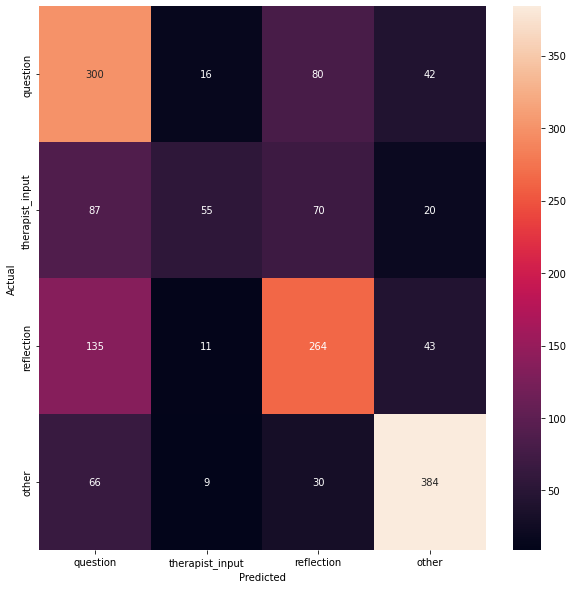

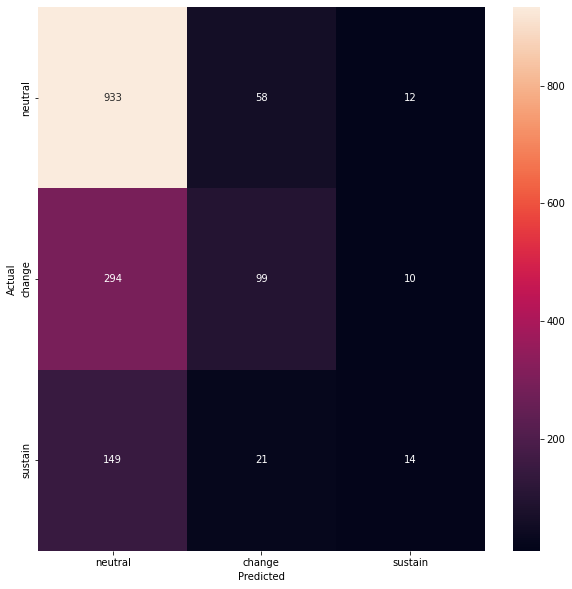

In [25]:
heatmap(df_therapist, 'therapist')
heatmap(df_client, 'client')

## List wrong predictions

In [26]:
from IPython.display import display

def list_wrong_predictions(dataframe, key):
    for predicted in processed_data[key]['behaviour_type_id_df'].behaviour_type_id:
      for actual in processed_data[key]['behaviour_type_id_df'].behaviour_type_id:
        if predicted != actual and processed_data[key]['conf_mat'][actual, predicted] >= 10:
          print("'{}' predicted as '{}' : {} examples.".format(processed_data[key]['id_to_behaviour'][actual], processed_data[key]['id_to_behaviour'][predicted], processed_data[key]['conf_mat'][actual, predicted]))
          display(dataframe.loc[processed_data[key]['indices_test'][(processed_data[key]['y_test'] == actual) & (processed_data[key]['y_pred'] == predicted)]][['behaviour_type', 'utterance_text']])
          print('')

In [27]:
list_wrong_predictions(df_therapist, 'therapist')
list_wrong_predictions(df_client, 'client')

'therapist_input' predicted as 'question' : 87 examples.


,behaviour_type,utterance_text
1858,therapist_input,yeah well david honestly wherever youre well work
8251,therapist_input,well small step go long way even things like t...
6855,therapist_input,okay okay want let know im little bite concern...
7845,therapist_input,oh smoke go cause problems anything else promi...
3216,therapist_input,let talk organize aa meet
...,...,...
7429,therapist_input,okay let pursue neighbor little bite um people...
7245,therapist_input,right well um look forward talk tomorrow im ho...
1972,therapist_input,youre concern health baby would love share nin...
6347,therapist_input,well mr smith thats medication sort



'reflection' predicted as 'question' : 135 examples.


,behaviour_type,utterance_text
97,reflection,success tell felt lose weight
282,reflection,mm drink something talk make easier offend
8732,reflection,things could better
8169,reflection,okay know whats whats happen day week
2993,reflection,great youve come reason stop drink like hangov...
...,...,...
510,reflection,see advantage reduce amount drink
6775,reflection,yeah ii see whatwhat youre say sure um thereth...
5579,reflection,okay dont job reckon um youll probably gonna k...
7890,reflection,know mean pretty cool everybody could kind put...



'other' predicted as 'question' : 66 examples.


,behaviour_type,utterance_text
7250,other,work meet people
9626,other,
6154,other,activities might end um choose
2796,other,lot alcohol
195,other,emily say well
...,...,...
1956,other,oh oh youre talk friends
8720,other,rather
1133,other,get
4868,other,seem real shame form gonna get way need find w...



'question' predicted as 'therapist_input' : 16 examples.


,behaviour_type,utterance_text
1205,question,itit kinda um prevent try stuff something else...
3299,question,understand youre experiment alcohol share effe...
6517,question,um look back mike uh start think use alcohol u...
1227,question,thats number one
2497,question,interest theres immediate feedback mean thats ...
8886,question,okay well say theres lot irritation particular...
9037,question,hmm let know oror know asthma things affect mi...
2509,question,um know mention try chantix um try uh zyban we...
2850,question,know like college gonna really hard especially...
140,question,sure sure okay um one thing id like maybe give...



'reflection' predicted as 'therapist_input' : 11 examples.


,behaviour_type,utterance_text
1261,reflection,especially church
6916,reflection,yeah cause youreyoure especially go back schoo...
3908,reflection,uh mean thats
8558,reflection,okay mean reduce
8014,reflection,yeah um could maybe talk ways um help uh deal ...
3838,reflection,thats common mean go know um ones gonna look
9688,reflection,know theres part go think place thats hard work
1757,reflection,uh seem fairly commit take medicine reduce ris...
5890,reflection,yeah information open eye ways talk roommate e...
2232,reflection,cancer get



'question' predicted as 'reflection' : 80 examples.


,behaviour_type,utterance_text
5673,question,would would like really happy life billy look ...
7496,question,mmhmm kind make realize youre actually tobacco...
1071,question,ever um place parent around
2889,question,seem like doesntisnt really concern time
314,question,idea also go along
...,...,...
518,question,kind explore little bite maybe advantage reduc...
9354,question,three weeks isnt
34,question,wanna go wanna change drink habit
2574,question,idea



'therapist_input' predicted as 'reflection' : 70 examples.


,behaviour_type,utterance_text
5792,therapist_input,okay thank um could youre cause tell really ar...
3715,therapist_input,well iii understand um like say rare feel musc...
5263,therapist_input,say five cigarettes time
4537,therapist_input,basically job meet students meet everybody twi...
5233,therapist_input,sound like allow really focus time unintelligi...
...,...,...
1848,therapist_input,yeah okay well really appreciate will even tal...
5545,therapist_input,wasnt perhaps police single little things well...
8634,therapist_input,isnt good combination
1774,therapist_input,summary minnesota state mankato security repor...



'other' predicted as 'reflection' : 30 examples.


,behaviour_type,utterance_text
425,other,really youre drivers seat kind put card table ...
206,other,youve do youve get really good track record uh...
8414,other,kind
2915,other,um know clients express really value freedom d...
7928,other,thats really good decision
1396,other,yeah time maybe job people felt social anxiety...
6523,other,thats fine
2678,other,thats really encourage think good youll feel a...
3702,other,good well youve get good plan well go check ma...
7821,other,coffee tea yeah youve hear im sure



'question' predicted as 'other' : 42 examples.


,behaviour_type,utterance_text
8024,question,unintelligible 001312 people okay anything els...
7413,question,yeah could see um may ask also single mom
7502,question,yeah something youd interest
6465,question,oh oh okay um around um ever feel feel bad oro...
6867,question,well thats great thats halfway keep give one t...
3948,question,uhhuh overall goal work towards
9380,question,yeah
9336,question,yeah
7934,question,right know
686,question,okay



'therapist_input' predicted as 'other' : 20 examples.


,behaviour_type,utterance_text
5171,therapist_input,yeah yeah
3505,therapist_input,yes
4459,therapist_input,uh im case manager health plan understand come...
8376,therapist_input,thats certainly true yes know people whove par...
7853,therapist_input,okay well thank listen honestly really worry s...
7139,therapist_input,know many millions people think racially um hmm
3214,therapist_input,yeah things thatthat often put people touch bu...
3892,therapist_input,yeah um nicorette gum nicotine appetite suppre...
6930,therapist_input,mmhmm uh mean lesser two evils get
5257,therapist_input,okay continue



'reflection' predicted as 'other' : 43 examples.


,behaviour_type,utterance_text
8097,reflection,okay yes get real sense ive gotta something
6945,reflection,mmhmm didnt go college
8875,reflection,yeah
1237,reflection,mm even though important maybe dont know impor...
3774,reflection,nothing okay
7113,reflection,get lot practice
445,reflection,right right right appointments time
5611,reflection,hmm get along really well
7145,reflection,thats great word yeah um
2471,reflection,mmhmm war go



'change' predicted as 'neutral' : 294 examples.


,behaviour_type,utterance_text
229,change,dont know think uh could get job stuff stuff l...
7973,change,mmhmm
918,change,want
287,change,yeah
8793,change,oh right well whawhat talk know uh okay uh cof...
...,...,...
8106,change,uh um isis think weekdays really need
4373,change,yeah dont wanna person
7891,change,yeah
9455,change,well hehe inside first time ever inside hes dr...



'sustain' predicted as 'neutral' : 149 examples.


,behaviour_type,utterance_text
5580,sustain,yeah yeah get bore stuff
6544,sustain,um know normally drink drink one two drink sto...
4938,sustain,could could also backfire feel could ridicule ...
9323,sustain,ive think easy would deal p
8160,sustain,yeah yeah limit ive workforce even work mean d...
...,...,...
5815,sustain,um im yeah like drink mean know obviously ii u...
7796,sustain,um well wanna say drink problem think id proba...
3899,sustain,know mean like say three days like
9597,sustain,yeah know



'neutral' predicted as 'change' : 58 examples.


,behaviour_type,utterance_text
2219,neutral,want make sure theres nothing change know
7569,neutral,werent best friends could come together know b...
5117,neutral,like say friend talk andand pretty ive see pic...
7521,neutral,andand really want best
7573,neutral,well mind say go way cant make turn way cant c...
1369,neutral,um dont know kind havent really tell anyone me...
1713,neutral,mean ill deal come
253,neutral,yeah like unintelligible 002813 id get polytec...
1963,neutral,wanna stay friends dont want dont want
7188,neutral,seven drink week doesnt seem like much



'sustain' predicted as 'change' : 21 examples.


,behaviour_type,utterance_text
7798,sustain,guess guess problems police school really dont...
5142,sustain,well research chronic inhaler find steroids th...
5787,sustain,well get question youre doctor dont guy come s...
8156,sustain,mean right think im three seem like know even ...
939,sustain,right yeah mean doesnt asthma yeah dont hasnt ...
8917,sustain,yeah phone im like grocery store im kind look ...
8236,sustain,know gonna say dont time schedule cant afford ...
1897,sustain,um im definitely think could probably itit com...
1899,sustain,many people kid vanish friends dont wanna pers...
1454,sustain,dont know guess friends like one friends decid...



'neutral' predicted as 'sustain' : 12 examples.


,behaviour_type,utterance_text
4582,neutral,really know really enjoy team set know people ...
7375,neutral,yeah yeah smoke dont smoke around try really h...
8878,neutral,ii dont go dont go dont go stuff dont go purse...
9103,neutral,yeah one point night though go cigarette join ...
6897,neutral,im um situations dont know dont know mean im c...
6304,neutral,cant really dont really know publish stuff ive...
7493,neutral,oh absolutely mean think fun thing friends cer...
7377,neutral,ii dont know mean try really hard smoke around...
6031,neutral,yeah mean alcohol prevalent society around whe...
463,neutral,lot fun didnt dance



'change' predicted as 'sustain' : 10 examples.


,behaviour_type,utterance_text
3411,change,would pretty upset yeah dont really condone al...
8629,change,smoke relate diabetes
6045,change,although didnt call right away really need hel...
543,change,well yeah mean weve marry 25 years uh weve nev...
8903,change,well something relax dont often probably could...
1919,change,well ii keep kid want almost like push sign li...
8453,change,oh certainly energy isis iwhat mean need know ...
4137,change,mean really uncomfortable know gonorrhea reall...
1943,change,know find would really piss
2419,change,iits really hard take right mean yeah iive nev...


## Model Evaluation

In [28]:
from sklearn import metrics

def model_evaluation(dataframe, key):
    print(metrics.classification_report(processed_data[key]['y_test'], processed_data[key]['y_pred'], target_names=dataframe['behaviour_type'].unique()))
    

In [29]:
model_evaluation(df_therapist, 'therapist')
model_evaluation(df_client, 'client')

                 precision    recall  f1-score   support

       question       0.51      0.68      0.58       438
therapist_input       0.60      0.24      0.34       232
     reflection       0.59      0.58      0.59       453
          other       0.79      0.79      0.79       489

       accuracy                           0.62      1612
      macro avg       0.62      0.57      0.57      1612
   weighted avg       0.63      0.62      0.61      1612

              precision    recall  f1-score   support

     neutral       0.68      0.93      0.78      1003
      change       0.56      0.25      0.34       403
     sustain       0.39      0.08      0.13       184

    accuracy                           0.66      1590
   macro avg       0.54      0.42      0.42      1590
weighted avg       0.61      0.66      0.60      1590

